<a href="https://colab.research.google.com/github/MajidNoorani/action-identification-with-Electroencephalogram-Signal/blob/main/Action_Identification_on_Electroencephalogram_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random

## Data
Download the [data](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset?resource=download) and put it in a directory

and then extract the csv data from it

In [2]:
# extracting eeg-data into data folder
with zipfile.ZipFile('/content/eeg-data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [3]:
df = pd.read_csv('/content/data/eeg-data.csv')
df.head()

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled


In [4]:
# keeping the rows with proper labels
unlabeled_eeg = df[df["label"] == "unlabeled"]
df = df.loc[df["label"] != "unlabeled"]
df = df.loc[df["label"] != "everyone paired"]

In [5]:
# list of all columns
df.columns

Index(['Unnamed: 0', 'id', 'indra_time', 'browser_latency', 'reading_time',
       'attention_esense', 'meditation_esense', 'eeg_power', 'raw_values',
       'signal_quality', 'createdAt', 'updatedAt', 'label'],
      dtype='object')

In [6]:
# drop not necessary columns
df.drop(
    [
        "indra_time",
        "Unnamed: 0",
        "browser_latency",
        "reading_time",
        "attention_esense",
        "meditation_esense",
        "updatedAt",
        "createdAt",
    ],
    axis=1,
    inplace=True,
)

df.reset_index(drop=True, inplace=True)
df.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


We only keep the signals which the values in signal_quality column is less than 128.

In this data, signal_quality = 0 shows the best calibration, and signal_quality = 200 shows the worst

In [7]:
QUALITY_THRESHOLD = 128
df = df.loc[df["signal_quality"] < QUALITY_THRESHOLD]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9958
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9954 non-null   int64 
 1   eeg_power       9954 non-null   object
 2   raw_values      9954 non-null   object
 3   signal_quality  9954 non-null   int64 
 4   label           9954 non-null   object
dtypes: int64(2), object(3)
memory usage: 466.6+ KB


### since the values in raw_values column are strings, we need to convert them



In [9]:
print('Type of data in each cell: ', type(df['raw_values'].values[0]))

Type of data in each cell:  <class 'str'>


In [10]:

df["raw_values"] = df["raw_values"].apply(lambda x: json.loads(x))
df.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


In [11]:
print('Type of data in each cell after converting: ', type(df['raw_values'].values[0]))
print('Type of data in each list after converting: ', type(df['raw_values'].values[0][0]))

Type of data in each cell after converting:  <class 'list'>
Type of data in each list after converting:  <class 'float'>


In [12]:
print('length of each sample: ', len(df['raw_values'].values[0]))

length of each sample:  512


### plotting a sample

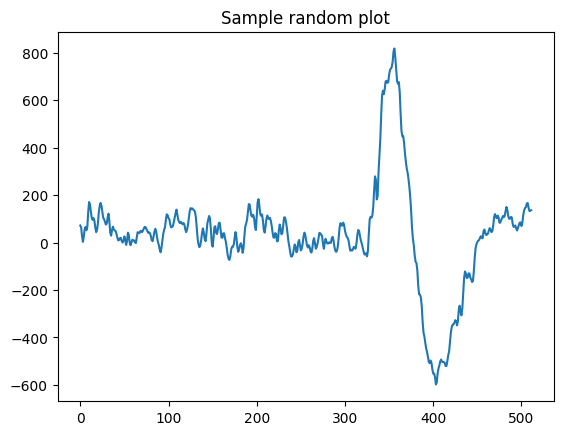

In [13]:
def view_eeg_plot(idx):
    data = df.loc[idx, "raw_values"]
    plt.plot(data)
    plt.title(f"Sample random plot")
    plt.show()

view_eeg_plot(7)

In [14]:
print('labels:\n ', df['label'].unique())
print('number of labels: ', df['label'].nunique())

labels:
  ['blinkInstruction' 'blink1' 'blink2' 'blink3' 'blink4' 'blink5'
 'relaxInstruction' 'relax' 'mathInstruction' 'math1' 'math2' 'math3'
 'math4' 'math5' 'math6' 'math7' 'math8' 'math9' 'math10' 'math11'
 'math12' 'musicInstruction' 'music' 'videoInstruction' 'video-ver1'
 'thinkOfItemsInstruction-ver1' 'thinkOfItems-ver1' 'colorInstruction1'
 'colorInstruction2' 'readyRound1' 'colorRound1-1' 'colorRound1-2'
 'colorRound1-3' 'colorRound1-4' 'colorRound1-5' 'colorRound1-6'
 'readyRound2' 'colorRound2-1' 'colorRound2-2' 'colorRound2-3'
 'colorRound2-4' 'colorRound2-5' 'colorRound2-6' 'readyRound3'
 'colorRound3-1' 'colorRound3-2' 'colorRound3-3' 'colorRound3-4'
 'colorRound3-5' 'colorRound3-6' 'readyRound4' 'colorRound4-1'
 'colorRound4-2' 'colorRound4-3' 'colorRound4-4' 'colorRound4-5'
 'colorRound4-6' 'readyRound5' 'colorRound5-1' 'colorRound5-2'
 'colorRound5-3' 'colorRound5-4' 'colorRound5-5' 'colorRound5-6'
 'video-ver2' 'thinkOfItemsInstruction-ver2' 'thinkOfItems-ver2']
nu

In [15]:
def change_labels(label):
  # we put the similar labels in the same category
  # the order of the following list is important
  ref = ['blinkInstruction', 'blink', 'mathInstruction', 'math', 'thinkOfItemsInstruction', 'thinkOfItems', 'videoInstruction', 'video', 'colorRound1', 'colorRound2', 'colorRound3', 'colorRound4', 'colorRound5' , 'colorInstruction', 'readyRound']
  for word in ref:
    if word in label:
      return word
  else:
    return label


In [16]:
df['label'] = df['label'].apply(change_labels)

In [17]:
print('labels after conversion:\n ', df['label'].unique())
print('number of labels after conversion: ', df['label'].nunique())

labels after conversion:
  ['blinkInstruction' 'blink' 'relaxInstruction' 'relax' 'mathInstruction'
 'math' 'musicInstruction' 'music' 'videoInstruction' 'video'
 'thinkOfItemsInstruction' 'thinkOfItems' 'colorInstruction' 'readyRound'
 'colorRound1' 'colorRound2' 'colorRound3' 'colorRound4' 'colorRound5']
number of labels after conversion:  19



---

Plottig the number of samples in each category to see whether they are balanced or not.


as we can see this data is imbalanced

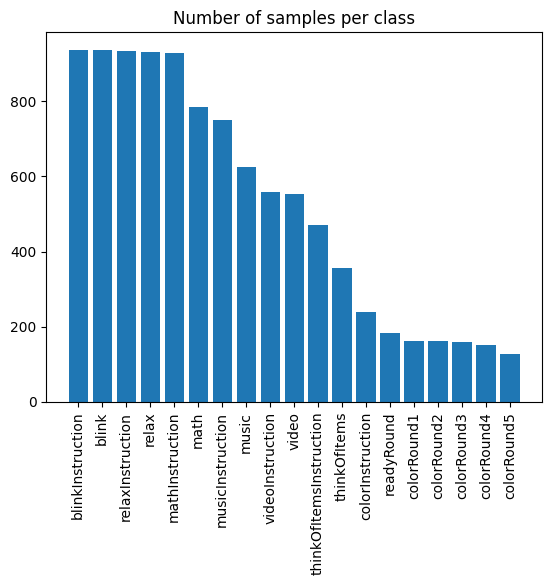

In [18]:
plt.bar(df['label'].unique(), df["label"].value_counts())
plt.xticks(rotation=90)
plt.title("Number of samples per class")
plt.show()

## Label encoding
Since the labels are strings, we need to convert them

In [19]:
le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(df["label"])
df["label"] = le.transform(df["label"])

In [20]:
df['label'].unique()

array([ 1,  0, 14, 13,  9,  8, 11, 10, 18, 17, 16, 15,  2, 12,  3,  4,  5,
        6,  7])

### Scaling

Data normalization is ver important in neural networks and it help them a lot

to get better results from them. we use MinMaxScaler as the normalizer

In [21]:
scaler = preprocessing.MinMaxScaler()

series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in df["raw_values"]
]

In [22]:
labels_list = [i for i in df["label"]]

splitting train and test sets and adjusting the shapes and types

In [23]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    series_list, labels_list, test_size=0.15, random_state=42, shuffle=True
)

print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

x_train = np.asarray(x_train).astype(np.float32).reshape(-1, 512, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, 512, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

Length of x_train : 8460
Length of x_test : 1494
Length of y_train : 8460
Length of y_test : 1494


## Setup and Config

In [24]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

## conver data to tf.data.dataset format and batching

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [26]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>

# Class weights

Since the data is imbalanced we need to specify the weight of each class to

prevent it from being fitted on the classes with higher number of samples


In [27]:
vals_dict = {}
for i in df["label"]:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{1: 0.9872413100261201, 0: 0.975989551938919, 14: 0.9841269841269842, 13: 0.9061683745228049, 9: 0.9838255977496484, 8: 0.9059674502712477, 11: 0.9847297568816556, 10: 0.9063692987743621, 18: 0.9838255977496484, 17: 0.9057665260196905, 16: 0.9373116335141651, 15: 0.9065702230259193, 2: 0.9211372312638135, 12: 0.9525818766325096, 3: 0.9245529435402853, 4: 0.943841671689773, 5: 0.9641350210970464, 6: 0.981514968856741, 7: 0.9443439823186659}


# History plot

In [28]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = math.ceil(total_plots / cols)

    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, i+1)
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

# Model

In [29]:
def create_model():
    input_layer = keras.Input(shape=(512, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(df['label'].nunique(), activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [30]:
conv_model = create_model()
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 256, 32)           128       
                                                                 
 batch_normalization (Batch  (None, 256, 32)           128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 64)           6208      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 128)           41088 

## callbacks and optimizers

In [31]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()

## compile and train

In [32]:
conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

Epoch 1/30
133/133 [==============================] - 27s 85ms/step - loss: 13.7333 - top_k_categorical_accuracy: 0.2719 - auc: 0.6538 - precision: 0.1207 - recall: 0.0017 - val_loss: 4.2059 - val_top_k_categorical_accuracy: 0.2209 - val_auc: 0.6393 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - 11s 86ms/step - loss: 3.2957 - top_k_categorical_accuracy: 0.3175 - auc: 0.7005 - precision: 0.4286 - recall: 3.5461e-04 - val_loss: 3.2605 - val_top_k_categorical_accuracy: 0.2202 - val_auc: 0.6365 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - 13s 94ms/step - loss: 2.7791 - top_k_categorical_accuracy: 0.3378 - auc: 0.7198 - precision: 0.3846 - recall: 5.9102e-04 - val_loss: 3.0499 - val_top_k_categorical_accuracy: 0.2363 - val_auc: 0.6383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/30
133/133 [==========================

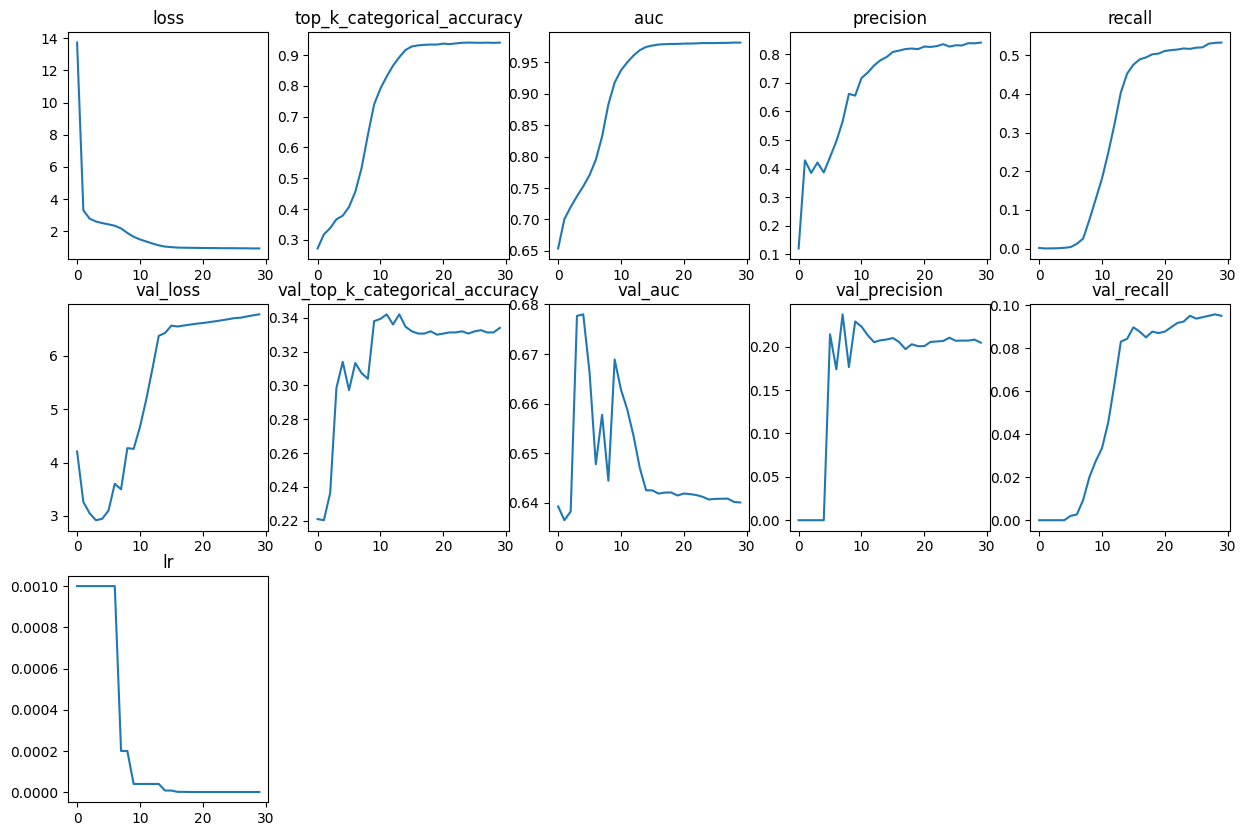

In [33]:
plot_history_metrics(conv_model_history)

24/24 [==============================] - 0s 13ms/step - loss: 6.7731 - top_k_categorical_accuracy: 0.3340 - auc: 0.6401 - precision: 0.2046 - recall: 0.0950
Loss : 6.77308988571167
Top 3 Categorical Accuracy : 0.33400267362594604
Area under the Curve (ROC) : 0.6400783061981201
Precision : 0.2046109437942505
Recall : 0.09504685550928116


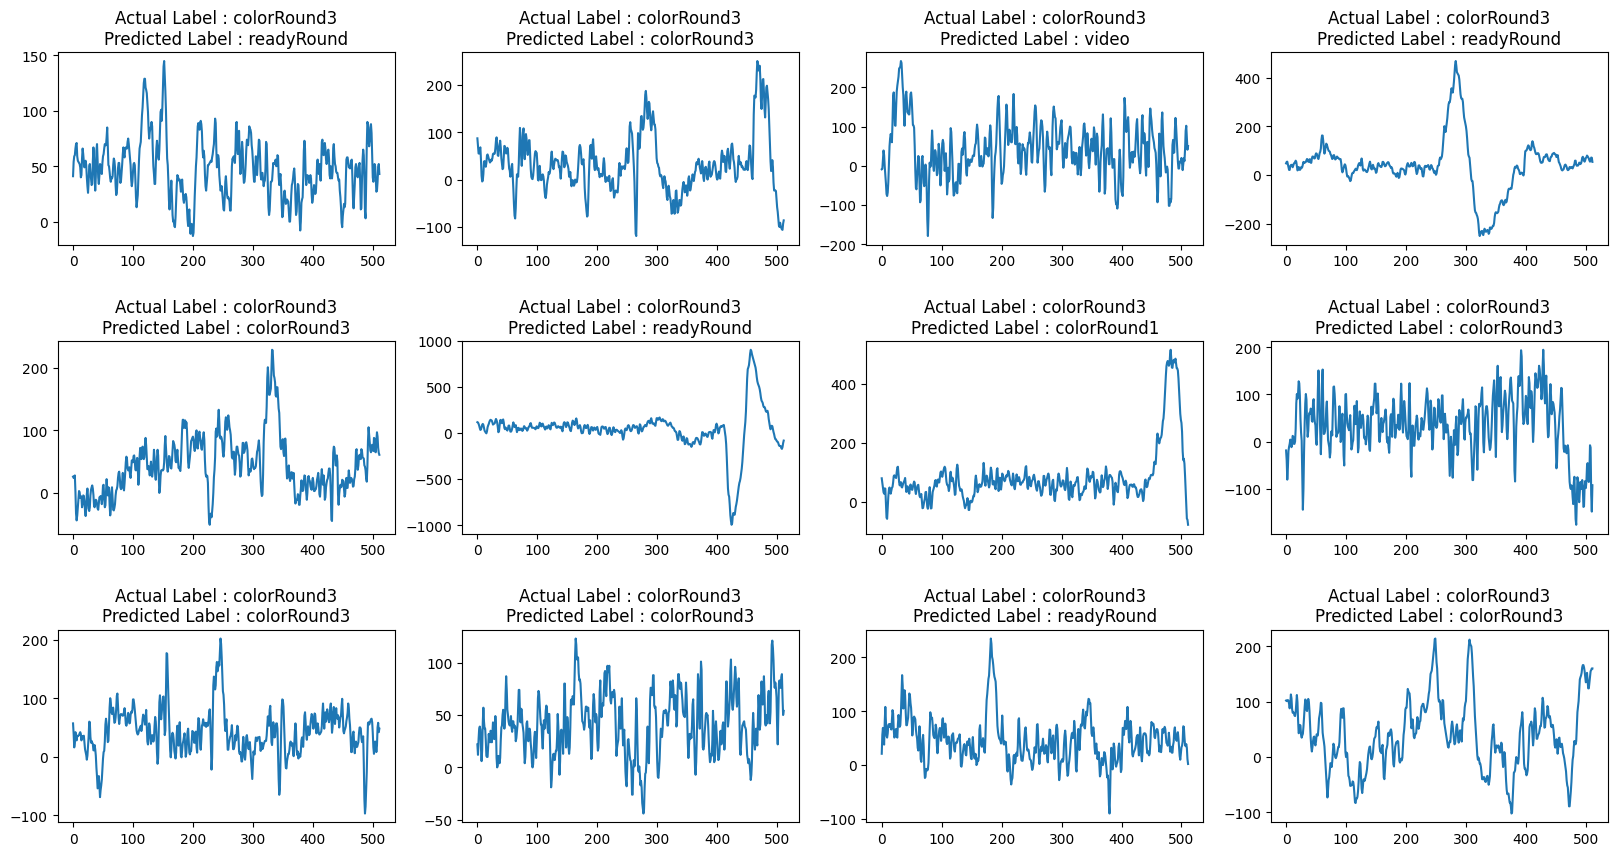

In [36]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")


def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(df))
    end_index = start_index + 11
    data = df.loc[start_index:end_index, "raw_values"]
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, 512, 1)]
    original_labels = df.loc[start_index:end_index, "label"]
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
    original_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in original_labels
    ]
    predicted_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in predicted_labels
    ]
    total_plots = 12
    cols = total_plots // 3
    rows = math,ceil(total_plots / cols)

    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, i+1)
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()


view_evaluated_eeg_plots(conv_model)